In [23]:
import os, gc
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import pandas as pd
from scipy.stats import skew, kurtosis

import joblib
from micromlgen import port
# from emlearn import 

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt
import numpy as np

# import numpy as np
# import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split

In [24]:
### 整理資料檔加上標籤與檔名 (同一個檔名的預測結果應該要調整為一致的預測，做為計算依據，所以加上檔名欄位用來調整預測結果的整體輸出)
def process_files(directory, label):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                content = file.read().strip()
                # Split content by newline to get individual records
                records = content.split('\n')
                for record in records:
                    values = list(map(float, record.split(',')))
                    values.append(label)
                    values.append(os.path.splitext(filename)[0])  # Add filename without extension
                    data.append(values)
    return data

# Process normal and abnormal directories
normal_data = process_files('vessel_data/normal', 0)
abnormal_data = process_files('vessel_data/abnormal', 1)
# Combine data
combined_data = normal_data + abnormal_data
# Create DataFrame
df = pd.DataFrame(combined_data)
print(len(df))
# Save DataFrame to CSV without scientific notation
df.to_csv('new_vessel_data.csv', index=False, float_format='%.6f')
print("Data has been processed and saved to new_vessel_data.csv")
del(combined_data, normal_data, abnormal_data, df)
gc.collect()

21099
Data has been processed and saved to new_vessel_data.csv


17224

In [25]:
### 整理資料檔加上標籤與檔名 (同一個檔名的預測結果應該要調整為一致的預測，做為計算依據)
### 這是test資料
def process_files(directory, label):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                content = file.read().strip()
                # Split content by newline to get individual records
                records = content.split('\n')
                for record in records:
                    values = list(map(float, record.split(',')))
                    values.append(label)
                    values.append(os.path.splitext(filename)[0])  # Add filename without extension
                    data.append(values)
    return data

# Process normal and abnormal directories
normal_data = process_files('vessel_data_test/normal', 0)
abnormal_data = process_files('vessel_data_test/abnormal', 1)
# Combine data
combined_data = normal_data + abnormal_data
# Create DataFrame
df = pd.DataFrame(combined_data)
print(len(df))
# Save DataFrame to CSV without scientific notation
df.to_csv('test_vessel_data.csv', index=False, float_format='%.6f')
print("Data has been processed and saved to test_vessel_data.csv")
del(combined_data, normal_data, abnormal_data, df)
gc.collect()

2349
Data has been processed and saved to test_vessel_data.csv


0

In [26]:
# 讀取 CSV 檔案
df = pd.read_csv('new_vessel_data.csv')

# 前 128 欄是 bin 資料
feature_cols = df.columns[:128]  # 0 ~ 127 columns name
fft_features = df[feature_cols]

# 計算統計資訊
mean_vals = fft_features.mean()
std_vals = fft_features.std()
min_vals = fft_features.min()
max_vals = fft_features.max()
skew_vals = fft_features.apply(skew)
kurtosis_vals = fft_features.apply(kurtosis)

# 合併成一個統計表格
stats_df = pd.DataFrame({
    'mean': mean_vals,
    'std': std_vals,
    'min': min_vals,
    'max': max_vals,
    'skewness': skew_vals,
    'kurtosis': kurtosis_vals
})

# 顯示前幾列結果
print(stats_df.head())

# 若要存成報表也可以：
# stats_df.to_csv('fft_statistics.csv', index_label='bin')

       mean       std       min        max   skewness    kurtosis
0  0.072623  0.362593  0.000000  10.070346  12.505651  197.432406
1  0.222521  0.477490  0.000001   9.453923   6.490015   63.748267
2  1.043787  1.898267  0.000001  26.367349   4.785520   33.759362
3  1.855885  3.522210  0.000001  54.694147   5.256613   41.656221
4  2.190519  4.254986  0.000001  72.751427   5.225895   40.120404


In [27]:
# 前面 128 欄(0~127)是數值資料，第129欄是 label (0,1)，最後130欄是檔案 ID
# normal files = 162, abnormal files = 18, total files = 180.
data = pd.read_csv('new_vessel_data.csv')   
print(len(data))

# 統計每個檔案的樣本數
file_sample_counts = data.iloc[:, 129].value_counts()
print(len(file_sample_counts))
print(file_sample_counts.index[0], file_sample_counts.values[0])

# 顯示每個樣本檔案中的片段數與標籤
# np.where(data.iloc[:,-1] == file_sample_counts.index[i])[0][0]
# 這會找出該檔案 ID 在資料中第一次出現的位置（row index）
# data.loc[...][-2]
# 這是取出該 row 的倒數第二欄，也就是第 129 欄（label）。
print("filename cuts label")
for i in range(len(file_sample_counts)):
    print(file_sample_counts.index[i], file_sample_counts.values[i], \
          int(data.loc[np.where(data.iloc[:,-1] == file_sample_counts.index[i])[0][0]][-2]))

### 2881 / 21728 = 11.88 % 這是正樣本比例     

21099
175
1640576455 370
filename cuts label
1640576455 370 0
1677115077 355 0
1676512504 318 0
1677637880 290 0
1678238057 286 0
1676509954 271 1
1640575471 263 0
1676945476 230 0
1640575501 221 0
1641432105 216 1
1678236643 204 0
1677113259 201 0
1677631931 196 0
1676511869 194 0
1676514365 192 0
1676513402 190 0
1676945809 188 0
1677722865 188 0
1676519359 186 0
1677721510 182 0
1641435831 181 0
1678266663 175 1
1641442599 174 0
1678153031 172 0
1641438314 171 0
1641430374 168 1
1641432704 167 0
1677720890 166 0
1641433751 166 0
1676517163 165 0
1678238027 164 0
1677721821 162 0
1677126362 162 0
1640575433 157 0
1676517194 156 0
1678236760 156 0
1641432754 156 0
1677720998 155 0
1676945743 154 0
1678331891 154 0
1676511581 153 1
1641435808 151 0
1676512356 151 0
1678238384 150 0
1678248100 148 0
1676512214 148 0
1678328298 147 0
1677114511 146 0
1678266730 146 1
1676513114 146 0
1677126224 144 0
1677633286 141 1
1678237649 141 0
1677725773 140 0
1678329919 137 0
1640575368 133 0
167

# gen_data

In [28]:
# 避免資料洩漏，根據檔名分配 train test data
# 讀取資料
def gen_data(test_size, random_state):
    data = pd.read_csv('new_vessel_data.csv')
    
    # 取得每個檔案的第一筆樣本的 label
    file_labels = data.groupby(data.columns[129]).first()[data.columns[128]]
    
    # 以檔案為單位進行 stratified split（依據 label 分層）
    train_ids, test_ids = train_test_split(
        file_labels.index, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=file_labels
    )
    
    # 根據 ID 過濾資料
    train_data = data[data.iloc[:, 129].isin(train_ids)]
    test_data = data[data.iloc[:, 129].isin(test_ids)]
    
    # 分別取出特徵、標籤與 ID
    X_train = train_data.iloc[:, :128].values
    y_train = train_data.iloc[:, 128].values
    ids_train = train_data.iloc[:, 129].values
    
    X_test = test_data.iloc[:, :128].values
    y_test = test_data.iloc[:, 128].values
    ids_test = test_data.iloc[:, 129].values
    # 計算每個集合中（以檔案為單位）的正負樣本數
    train_label_counts = file_labels.loc[train_ids].value_counts()
    test_label_counts = file_labels.loc[test_ids].value_counts()
    print("train_label_counts", train_label_counts, '\n')
    print("test_label_counts", test_label_counts, '\n')
    return X_train, y_train, ids_train, X_test, y_test, ids_test

# RandomForestClassifier

In [29]:
# 訓練模型
def train_rf_clf_model():
    n_estimators = 7
    max_depth = 15
    graph = True
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf_clf.fit(X_train, y_train)   ## 訓練模型

    # # 保存模型
    joblib.dump(rf_clf, 'random_forest_model.pkl')

    ##################################### predict valida
    # 進行預測
    y_pred = rf_clf.predict(X_test)
    y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]   # 這是預測 label 為 1 的機率
    
    # 根據 ID (檔名) 調整預測結果
    unique_ids = np.unique(ids_test)  # 全部檔名
    # print("number of unique_ids : ", len(unique_ids))
    adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
    
    for unique_id in unique_ids:
        idx = np.where(ids_test == unique_id)     # a data index list of ids_test
        # print(idx)
        if np.any(adjusted_y_pred[idx] == 1):     # 只要有任何預測是 1  其他預測結果都修正為 1
            adjusted_y_pred[idx] = 1              # 其他預測結果都修正為 1
            # print(idx)
            # print(adjusted_y_pred[idx])
        else:
            adjusted_y_pred[idx] = 0   # 整個檔案的每個片段都預測為 0
    
    # 計算新的指標
    # [0][0] 用於獲取第一個匹配的索引，因為每個 unique_id 可能對應多個數據點，但我們只需要其中一個。
    adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
    adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
    # adjusted_y_true   
    # adjusted_y_pred_final 
    # adjusted_y_pred = adjusted_y_pred.astype(float)

    print("*** this result predict use Valid set")
    print("number of unique_ids : ", len(unique_ids))
    # 計算混淆矩陣
    cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
    print(cm)
    if graph:
        # 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    
    # 計算 F1 Score
    f1 = f1_score(adjusted_y_true, adjusted_y_pred_final)
    
    # 計算 ROC AUC Score
    roc_auc = roc_auc_score(adjusted_y_true, adjusted_y_pred_final)
    
    # 計算準確率
    accuracy = accuracy_score(adjusted_y_true, adjusted_y_pred_final)
    
    # 輸出評分結果
    # print("*** this result predict use Valid set")
    print(f">>> F1 Score: {f1:.3f}")
    print(f"ROC AUC Score: {roc_auc:.3f}")
    print(f"accuracy_score: {accuracy:.3f}")
    print(f"Model accuracy: {accuracy:.3f}, n_estimators: {n_estimators}, max_depth: {max_depth}\n")

    if graph:
        # 繪製 ROC 曲線
        fpr, tpr, _ = roc_curve(adjusted_y_true, adjusted_y_pred_final)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    ######################################## test set
    # 前面 128 欄(0~127)是數值資料，第129欄是 label (0,1)，最後130欄是檔案 ID
    # normal files = 162, abnormal files = 18, total files = 180.
    test_data = pd.read_csv('test_vessel_data.csv')    
    
    # 分割特徵和標籤
    test_X = test_data.iloc[:, :128].values   # 資料
    test_y = test_data.iloc[:, 128].values    # 標籤
    test_ids = test_data.iloc[:, 129].values  # 檔名
    
    # 進行預測
    y_pred = rf_clf.predict(test_X)
    y_pred_proba = rf_clf.predict_proba(test_X)[:, 1]   # 這是預測 label 為 1 的機率
    
    # 根據 ID (檔名) 調整預測結果
    unique_ids = np.unique(test_ids)  # 全部檔名
    # print("number of unique_ids : ", len(unique_ids))
    adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
    
    for unique_id in unique_ids:
        idx = np.where(test_ids == unique_id)     # a data index list of ids_test
        # print(idx)
        if np.any(adjusted_y_pred[idx] == 1):     # 只要有任何預測是 1  其他預測結果都修正為 1
            adjusted_y_pred[idx] = 1              # 其他預測結果都修正為 1
            # print(idx)
            # print(adjusted_y_pred[idx])
        else:
            adjusted_y_pred[idx] = 0   # 整個檔案的每個片段都預測為 0
    
    # 計算新的指標
    # [0][0] 用於獲取第一個匹配的索引，因為每個 unique_id 可能對應多個數據點，但我們只需要其中一個。
    adjusted_y_true = np.array([test_y[np.where(test_ids == unique_id)[0][0]] for unique_id in unique_ids])
    adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(test_ids == unique_id)[0][0]] for unique_id in unique_ids])
    # adjusted_y_true   
    # adjusted_y_pred_final 
    # adjusted_y_pred = adjusted_y_pred.astype(float)

    print("*** this result predict use test set")
    print("number of unique_ids : ", len(unique_ids))
    # 計算混淆矩陣
    cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
    print(cm)
    if graph:
        # 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    
    # 計算 F1 Score
    f1 = f1_score(adjusted_y_true, adjusted_y_pred_final)
    
    # 計算 ROC AUC Score
    roc_auc = roc_auc_score(adjusted_y_true, adjusted_y_pred_final)
    
    # 計算準確率
    accuracy = accuracy_score(adjusted_y_true, adjusted_y_pred_final)
    
    # 輸出評分結果
    # print("*** this result predict use test set")
    print(f">>> F1 Score: {f1:.3f}")
    print(f"ROC AUC Score: {roc_auc:.3f}")
    print(f"accuracy_score: {accuracy:.3f}")
    print(f"Model accuracy: {accuracy:.3f}, n_estimators: {n_estimators}, max_depth: {max_depth}\n")
    
    # # # 保存模型
    # joblib.dump(rf_clf, 'random_forest_model.pkl')
    
    if graph:
        # 繪製 ROC 曲線
        fpr, tpr, _ = roc_curve(adjusted_y_true, adjusted_y_pred_final)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    return rf_clf

# train_rf_clf_model()

test_size 0.1, random_state 80 

train_label_counts 128
0    143
1     14
Name: count, dtype: int64 

test_label_counts 128
0    16
1     2
Name: count, dtype: int64 

*** this result predict use Valid set
number of unique_ids :  18
[[14  2]
 [ 0  2]]


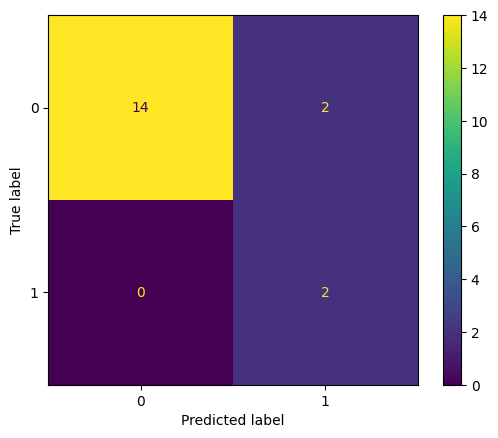

>>> F1 Score: 0.667
ROC AUC Score: 0.938
accuracy_score: 0.889
Model accuracy: 0.889, n_estimators: 7, max_depth: 15



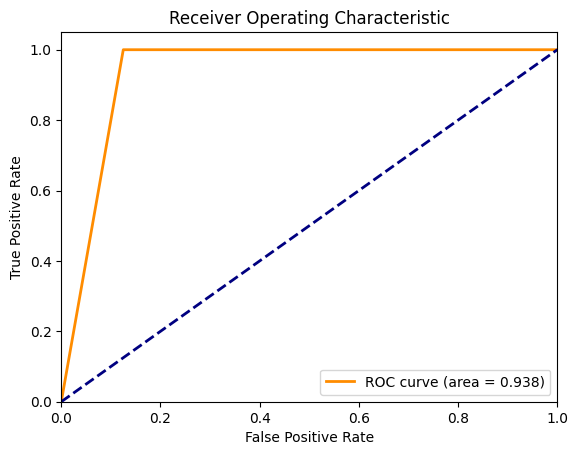

*** this result predict use test set
number of unique_ids :  21
[[15  3]
 [ 0  3]]


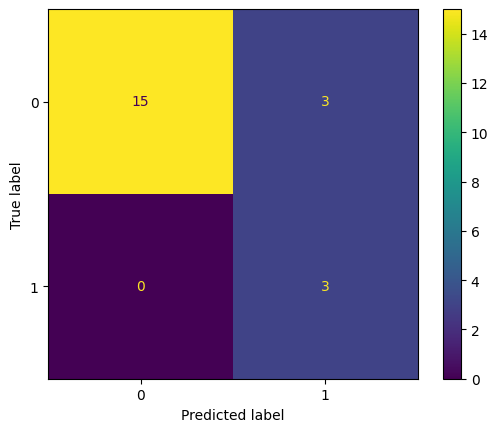

>>> F1 Score: 0.667
ROC AUC Score: 0.917
accuracy_score: 0.857
Model accuracy: 0.857, n_estimators: 7, max_depth: 15



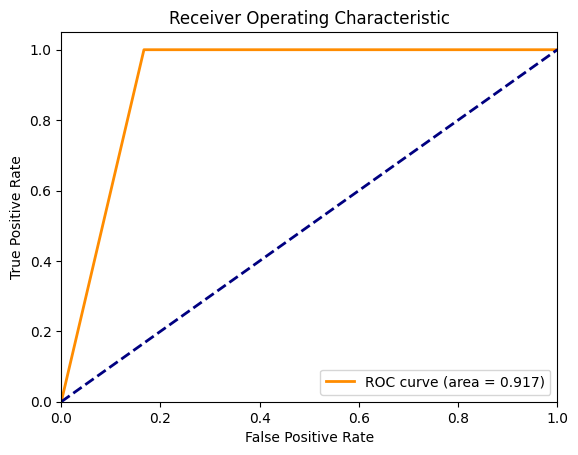

**********************************************************************************************


In [30]:
s = 0.1
r = 80
print("test_size {}, random_state {}".format(s,r), '\n')
X_train, y_train, ids_train, X_test, y_test, ids_test = gen_data(test_size=s, random_state=r)
rf_clf = train_rf_clf_model()
print("**********************************************************************************************")

In [31]:
### SVC method model can not run in ESP32 module, so give up this model 

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# import joblib

# # Train SVM model
# svm_clf = SVC(kernel='linear', random_state=42, probability=True)
# svm_clf.fit(X_train, y_train)

# # Predict on test set
# y_pred = svm_clf.predict(X_test)
# y_pred_proba = svm_clf.predict_proba(X_test)[:, 1]

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)

# # Calculate F1 score
# f1 = f1_score(y_test, y_pred)

# # Calculate ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# print(f"SVM Model accuracy: {accuracy:.2f}")
# print(f"SVM Model F1 score: {f1:.2f}")
# print(f"SVM Model ROC AUC score: {roc_auc:.2f}")

# # Save SVM model weights
# joblib.dump(svm_clf, 'svm_model.pkl')

# SGDClassifier

[[ 1 15]
 [ 1  1]]


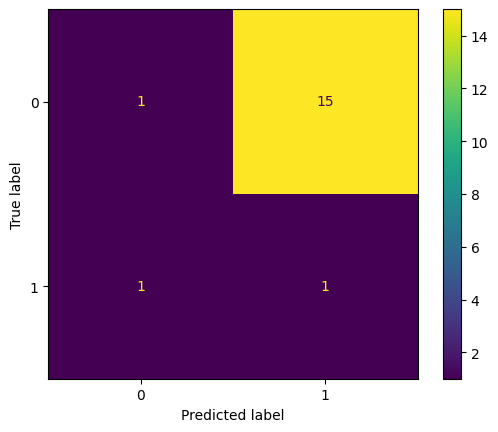

F1 Score: 0.1111111111111111
ROC AUC Score: 0.28125
accuracy_score: 0.1111111111111111


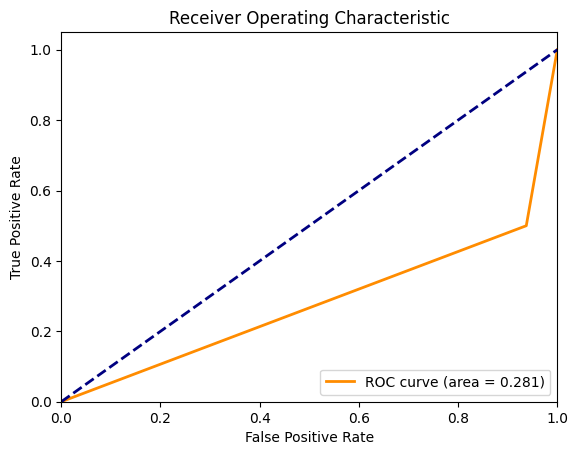

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib

# Train SVM model using SGDClassifier
svm_clf = SGDClassifier(loss='hinge', random_state=42)
svm_clf.fit(X_train, y_train)

# Save SVM model weights
joblib.dump(svm_clf, 'svm_model.pkl')

# 進行預測
y_pred = svm_clf.predict(X_test)
y_pred_proba = svm_clf.decision_function(X_test)

# 根據 ID 調整預測結果
unique_ids = np.unique(ids_test)
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
# adjusted_y_test = y_test  # 這不變即可

for unique_id in unique_ids:
    idx = np.where(ids_test == unique_id)
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):   # 只要有任何預測是 1 
    # if (sum(adjusted_y_pred[idx]) >= 1 ):   # 只要有任何筆預測是 1 
        adjusted_y_pred[idx] = 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0
        
# adjusted_y_pred = adjusted_y_pred.astype(float)
adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])

# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(adjusted_y_true, adjusted_y_pred_final)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(adjusted_y_true, adjusted_y_pred_final)

# 計算準確率
accuracy = accuracy_score(adjusted_y_true, adjusted_y_pred_final)

# 輸出評分結果
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"accuracy_score: {accuracy}")
# print(f"Model accuracy: {accuracy:.3f}, n_estimators: {n_estimators}, max_depth: {max_depth}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(adjusted_y_true, adjusted_y_pred_final)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# KNeighborsClassifier

[[9 7]
 [0 2]]


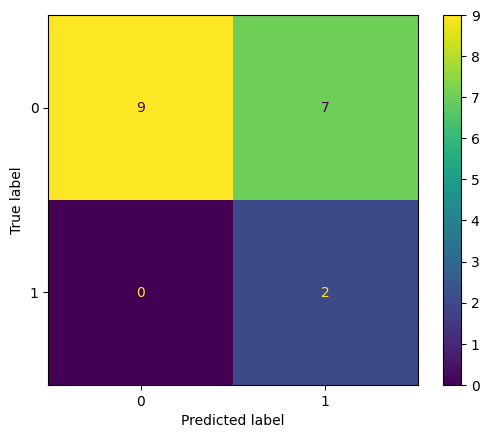

F1 Score: 0.3100686498855835
ROC AUC Score: 0.6717474142623843
accuracy_score: 0.4278937381404175
Model accuracy: 0.428


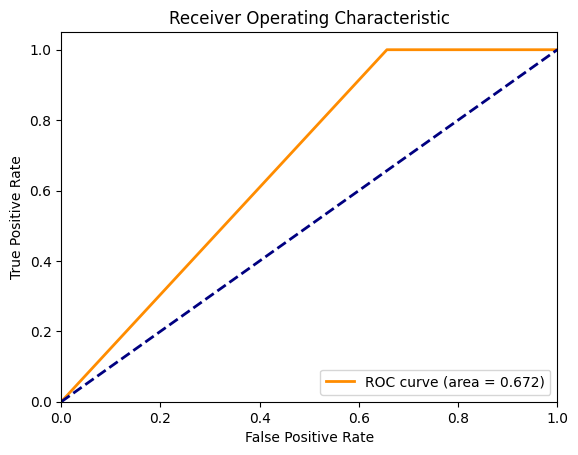

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib

# Train K-Nearest Neighbors model
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
# Save K-Nearest Neighbors model weights
joblib.dump(knn_clf, 'knn_model.pkl')

# 進行預測
y_pred = knn_clf.predict(X_test)
y_pred_proba = knn_clf.predict_proba(X_test)[:, 1]

# 根據 ID 調整預測結果
unique_ids = np.unique(ids_test)
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
# adjusted_y_test = y_test  # 這不變即可

for unique_id in unique_ids:
    idx = np.where(ids_test == unique_id)
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):   # 只要有任何預測是 1 
    # if (sum(adjusted_y_pred[idx]) >= 1 ):   # 只要有任何筆預測是 1 
        adjusted_y_pred[idx] = 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0
        
# adjusted_y_pred = adjusted_y_pred.astype(float)
adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])

# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(y_test, adjusted_y_pred)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(y_test, adjusted_y_pred)

# 計算準確率
accuracy = accuracy_score(y_test, adjusted_y_pred)

# 輸出評分結果
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"accuracy_score: {accuracy}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, adjusted_y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# DecisionTreeClassifier

[[ 1 15]
 [ 0  2]]


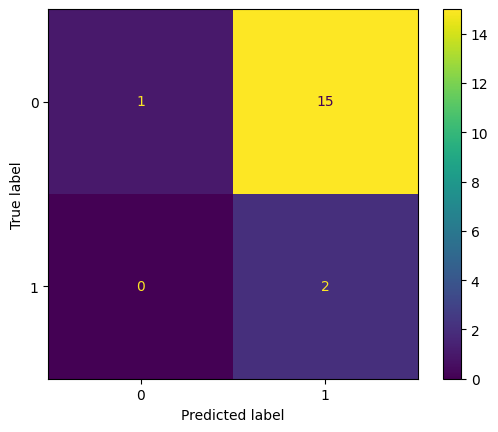

F1 Score: 0.23585726718885988
ROC AUC Score: 0.5220468154599891
accuracy_score: 0.16698292220113853
Model accuracy: 0.167


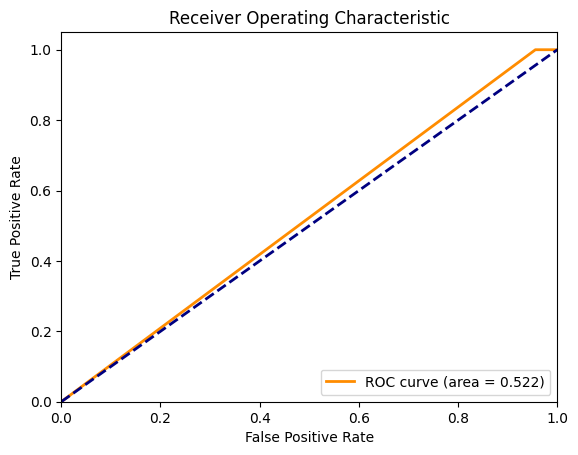

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib

# Train Decision Tree model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Save Decision Tree model weights
joblib.dump(dt_clf, 'decision_tree_model.pkl')

# 進行預測
y_pred = dt_clf.predict(X_test)
y_pred_proba = dt_clf.predict_proba(X_test)[:, 1]

# 根據 ID 調整預測結果
unique_ids = np.unique(ids_test)
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
# adjusted_y_test = y_test  # 這不變即可

for unique_id in unique_ids:
    idx = np.where(ids_test == unique_id)
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):   # 只要有任何預測是 1 
    # if (sum(adjusted_y_pred[idx]) >= 1 ):   # 只要有任何筆預測是 1 
        adjusted_y_pred[idx] = 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0
        
# adjusted_y_pred = adjusted_y_pred.astype(float)
adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])

# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(y_test, adjusted_y_pred)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(y_test, adjusted_y_pred)

# 計算準確率
accuracy = accuracy_score(y_test, adjusted_y_pred)

# 輸出評分結果
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"accuracy_score: {accuracy}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, adjusted_y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# GaussianNB

[[ 4 12]
 [ 0  2]]


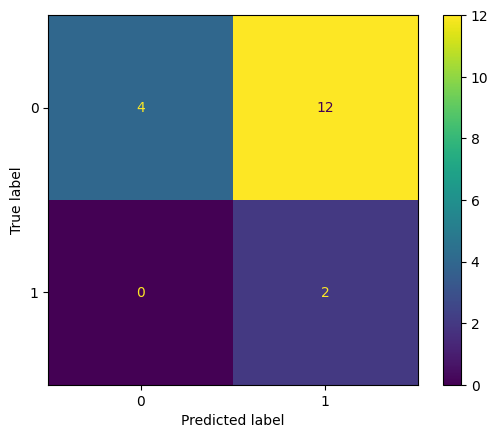

F1 Score: 0.2605769230769231
ROC AUC Score: 0.5813826891671203
accuracy_score: 0.2703984819734345
Model accuracy: 0.270


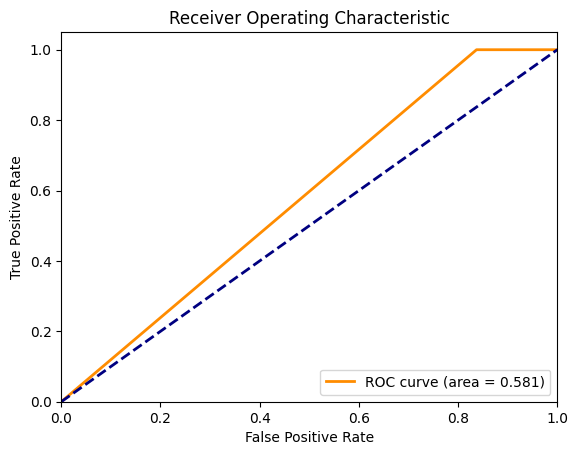

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib

# Train Naive Bayes model
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Save Naive Bayes model weights
joblib.dump(nb_clf, 'naive_bayes_model.pkl')

# 進行預測
y_pred = nb_clf.predict(X_test)
y_pred_proba = nb_clf.predict_proba(X_test)[:, 1]

# 根據 ID 調整預測結果
unique_ids = np.unique(ids_test)
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
# adjusted_y_test = y_test  # 這不變即可

for unique_id in unique_ids:
    idx = np.where(ids_test == unique_id)
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):   # 只要有任何預測是 1 
    # if (sum(adjusted_y_pred[idx]) >= 1 ):   # 只要有任何筆預測是 1 
        adjusted_y_pred[idx] = 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0
        
# adjusted_y_pred = adjusted_y_pred.astype(float)
adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])

# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(y_test, adjusted_y_pred)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(y_test, adjusted_y_pred)

# 計算準確率
accuracy = accuracy_score(y_test, adjusted_y_pred)

# 輸出評分結果
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"accuracy_score: {accuracy}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, adjusted_y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# XGBClassifier

[[16  0]
 [ 1  1]]


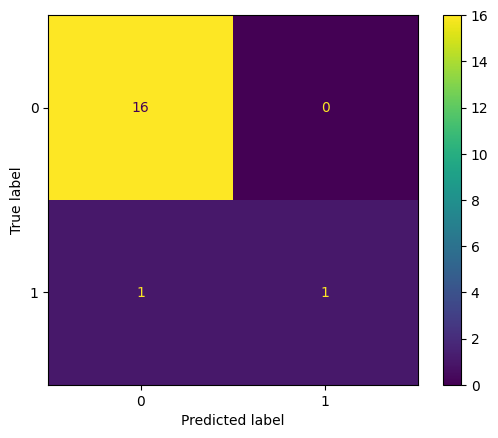

F1 Score: 0.7002398081534772
ROC AUC Score: 0.7693726937269373
accuracy_score: 0.9407020872865275
Model accuracy: 0.941


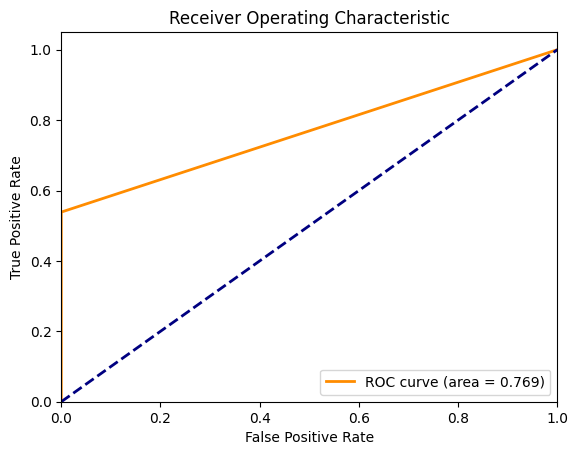

*** this result predict use test set
number of unique_ids :  21
[[18  0]
 [ 3  0]]


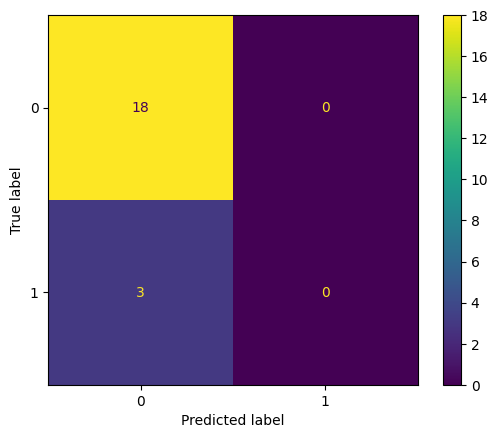

>>> F1 Score: 0.000
ROC AUC Score: 0.500
accuracy_score: 0.857
Model accuracy: 0.857


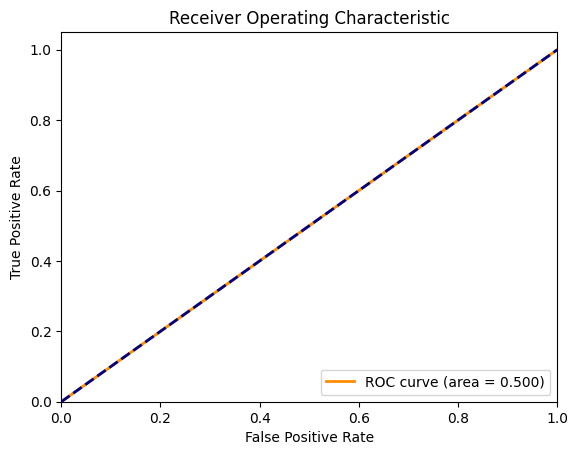

In [36]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib

# 訓練模型
xgb_clf = XGBClassifier(n_estimators=10, max_depth=4, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)

# 保存模型
joblib.dump(xgb_clf, 'XGBClassifier_model.pkl')

# 進行預測
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# 根據 ID 調整預測結果
unique_ids = np.unique(ids_test)
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果
# adjusted_y_test = y_test  # 這不變即可

for unique_id in unique_ids:
    idx = np.where(ids_test == unique_id)
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):   # 只要有任何預測是 1 
    # if (sum(adjusted_y_pred[idx]) >= 1 ):   # 只要有任何筆預測是 1 
        adjusted_y_pred[idx] = 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0
        
# adjusted_y_pred = adjusted_y_pred.astype(float)
adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])

# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(y_test, adjusted_y_pred)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(y_test, adjusted_y_pred)

# 計算準確率
accuracy = accuracy_score(y_test, adjusted_y_pred)

# 輸出評分結果
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"accuracy_score: {accuracy}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, adjusted_y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

######################################## test set ##########################################
# 前面 128 欄(0~127)是數值資料，第129欄是 label (0,1)，最後130欄是檔案 ID
# normal files = 162, abnormal files = 18, total files = 180.
test_data = pd.read_csv('test_vessel_data.csv')    

# 分割特徵和標籤
test_X = test_data.iloc[:, :128].values   # 資料
test_y = test_data.iloc[:, 128].values    # 標籤
test_ids = test_data.iloc[:, 129].values  # 檔名

# 進行預測
y_pred = xgb_clf.predict(test_X)
y_pred_proba = xgb_clf.predict_proba(test_X)[:, 1]   # 這是預測 label 為 1 的機率

# 根據 ID (檔名) 調整預測結果
unique_ids = np.unique(test_ids)  # 全部檔名
# print("number of unique_ids : ", len(unique_ids))
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果

for unique_id in unique_ids:
    idx = np.where(test_ids == unique_id)     # a data index list of ids_test
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):     # 只要有任何預測是 1  其他預測結果都修正為 1
        adjusted_y_pred[idx] = 1              # 其他預測結果都修正為 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0   # 整個檔案的每個片段都預測為 0

# 計算新的指標
# [0][0] 用於獲取第一個匹配的索引，因為每個 unique_id 可能對應多個數據點，但我們只需要其中一個。
adjusted_y_true = np.array([test_y[np.where(test_ids == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(test_ids == unique_id)[0][0]] for unique_id in unique_ids])

print("*** this result predict use test set")
print("number of unique_ids : ", len(unique_ids))
# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(adjusted_y_true, adjusted_y_pred_final)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(adjusted_y_true, adjusted_y_pred_final)

# 計算準確率
accuracy = accuracy_score(adjusted_y_true, adjusted_y_pred_final)

# 輸出評分結果
# print("*** this result predict use test set")
print(f">>> F1 Score: {f1:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")
print(f"accuracy_score: {accuracy:.3f}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(adjusted_y_true, adjusted_y_pred_final)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# DNN model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8932 - loss: 0.3305 - val_accuracy: 0.8724 - val_loss: 0.2586
Epoch 2/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8942 - loss: 0.2845 - val_accuracy: 0.8904 - val_loss: 0.2368
Epoch 3/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8972 - loss: 0.2718 - val_accuracy: 0.9056 - val_loss: 0.2240
Epoch 4/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9018 - loss: 0.2618 - val_accuracy: 0.9037 - val_loss: 0.2202
Epoch 5/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9088 - loss: 0.2501 - val_accuracy: 0.9156 - val_loss: 0.2031
Epoch 6/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9070 - loss: 0.2492 - val_accuracy: 0.9141 - val_loss: 0.2011
Epoch 7/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9116 - loss: 0.2449 - val_accuracy: 0.9175 - val_loss: 0.2031
Epoch 8/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9125 - loss: 0.2337 - val_accuracy: 0.

驗證損失: 0.22594261169433594
驗證準確率: 0.9188804626464844
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
[[11  5]
 [ 0  2]]


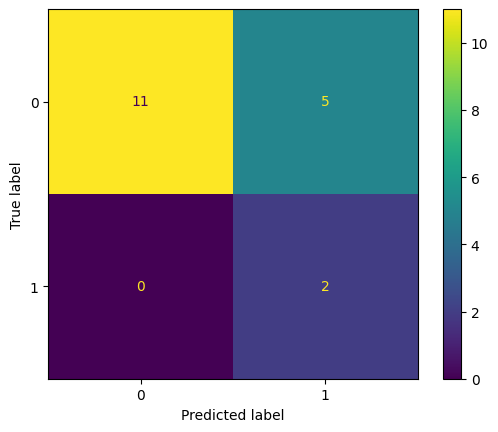

F1 Score: 0.41310975609756095
ROC AUC Score: 0.7904191616766467
accuracy_score: 0.6347248576850095
Model accuracy: 0.635


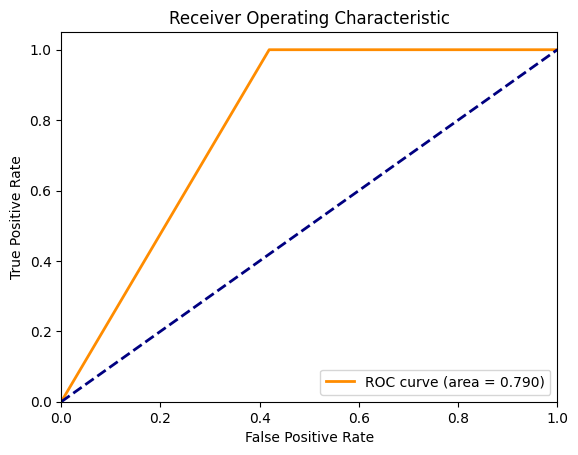

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score, roc_auc_score

# 建立模型
model = Sequential()
# 第一層（輸入層）
model.add(Dense(units=32, activation='relu', input_shape=(128,)))
# 第二層（隱藏層）
model.add(Dense(units=16, activation='relu'))
# 第三層（輸出層）
model.add(Dense(units=1, activation='sigmoid'))
# 編譯模型
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 顯示模型摘要
model.summary()

# 訓練模型
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=48,
                    validation_data=(X_test, y_test))

# 評估模型
loss, accuracy = model.evaluate(X_test, y_test)
print(f'驗證損失: {loss}')
print(f'驗證準確率: {accuracy}')

# 保存模型
model.save('dnn_model.h5')

# 進行預測
y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_classes = (y_pred > 0.5).astype("int32")

# 根據 ID 調整預測結果
unique_ids = np.unique(ids_test)
adjusted_y_pred = np.copy(y_pred_classes)     # 使用副本來存儲調整後的結果
# adjusted_y_test = y_test  # 這不變即可

for unique_id in unique_ids:
    idx = np.where(ids_test == unique_id)
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):   # 只要有任何預測是 1 
    # if (sum(adjusted_y_pred[idx]) >= 1 ):   # 只要有任何筆預測是 1 
        adjusted_y_pred[idx] = 1
        # print(idx)
        # print(adjusted_y_pred[idx])
    else:
        adjusted_y_pred[idx] = 0
        
# adjusted_y_pred = adjusted_y_pred.astype(float)
adjusted_y_true = np.array([y_test[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(ids_test == unique_id)[0][0]] for unique_id in unique_ids])

# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(y_test, adjusted_y_pred)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(y_test, adjusted_y_pred)

# 計算準確率
accuracy = accuracy_score(y_test, adjusted_y_pred)

# 輸出評分結果
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"accuracy_score: {accuracy}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(y_test, adjusted_y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
*** this result predict use test set
number of unique_ids :  21
[[18  0]
 [ 3  0]]


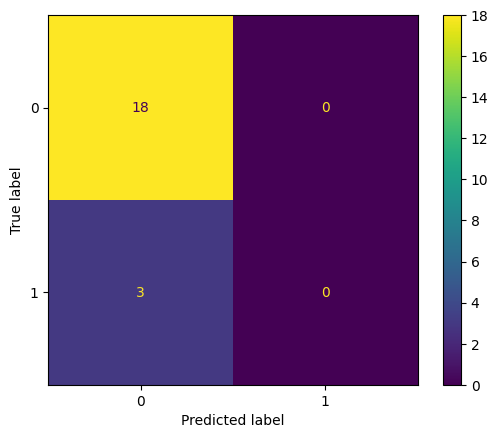

>>> F1 Score: 0.000
ROC AUC Score: 0.500
accuracy_score: 0.857
Model accuracy: 0.857


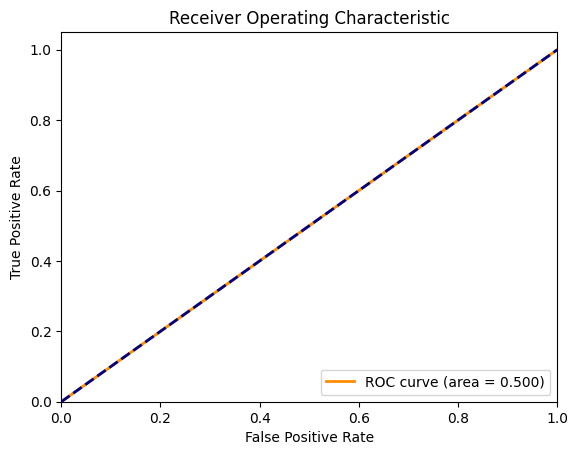

In [38]:
######################################## test set ##########################################
# 前面 128 欄(0~127)是數值資料，第129欄是 label (0,1)，最後130欄是檔案 ID
# normal files = 162, abnormal files = 18, total files = 180.
test_data = pd.read_csv('test_vessel_data.csv')    

# 分割特徵和標籤
test_X = test_data.iloc[:, :128].values   # 資料
test_y = test_data.iloc[:, 128].values    # 標籤
test_ids = test_data.iloc[:, 129].values  # 檔名

# 進行預測
y_pred = model.predict(test_X)
# y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_classes = (y_pred > 0.5).astype("int32")

# 根據 ID (檔名) 調整預測結果
unique_ids = np.unique(test_ids)  # 全部檔名
# print("number of unique_ids : ", len(unique_ids))
adjusted_y_pred = np.copy(y_pred)     # 使用副本來存儲調整後的結果

for unique_id in unique_ids:
    idx = np.where(test_ids == unique_id)     # a data index list of ids_test
    # print(idx)
    if np.any(adjusted_y_pred[idx] == 1):     # 只要有任何預測是 1  其他預測結果都修正為 1
        adjusted_y_pred[idx] = 1              # 其他預測結果都修正為 1
    else:
        adjusted_y_pred[idx] = 0   # 整個檔案的每個片段都預測為 0

# 計算新的指標
# [0][0] 用於獲取第一個匹配的索引，因為每個 unique_id 可能對應多個數據點，但我們只需要其中一個。
adjusted_y_true = np.array([test_y[np.where(test_ids == unique_id)[0][0]] for unique_id in unique_ids])
adjusted_y_pred_final = np.array([adjusted_y_pred[np.where(test_ids == unique_id)[0][0]] for unique_id in unique_ids])

print("*** this result predict use test set")
print("number of unique_ids : ", len(unique_ids))
# 計算混淆矩陣
cm = confusion_matrix(adjusted_y_true, adjusted_y_pred_final)
print(cm)
# 使用 ConfusionMatrixDisplay 來顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 計算 F1 Score
f1 = f1_score(adjusted_y_true, adjusted_y_pred_final)

# 計算 ROC AUC Score
roc_auc = roc_auc_score(adjusted_y_true, adjusted_y_pred_final)

# 計算準確率
accuracy = accuracy_score(adjusted_y_true, adjusted_y_pred_final)

# 輸出評分結果
# print("*** this result predict use test set")
print(f">>> F1 Score: {f1:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")
print(f"accuracy_score: {accuracy:.3f}")
print(f"Model accuracy: {accuracy:.3f}")

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(adjusted_y_true, adjusted_y_pred_final)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()